In this kernel, I will demonstrate the classification of chest X-ray images for pneumonia or normal. This is a binary image classification dataset. I will use Keras VGG-19 transfer learning.

I am also using imgaug for augmentation of images. Please visit my kernel [Data Augmentation in Python, TF, Keras, Imgaug](https://www.kaggle.com/curiousprogrammer/data-augmentation-in-python-tf-keras-imgaug) for more augmentation techniques.

For implementation using tensorflow hub ResNet-50, please visit my kernel [Chest X-Ray Image Classification - TF Hub ResNet50](https://www.kaggle.com/curiousprogrammer/chest-x-ray-image-classification-tf-hub-resnet50)

Let's start by importing necessary libraries.

In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# print(os.listdir("../input"))

import random
import warnings
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')

#File Operation libraries
import glob
from pathlib import Path

#Visualisation Libraries
import matplotlib.pyplot as plt
import seaborn as sns
# from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf
#Keras
from keras.layers import Dense, Conv2D, MaxPooling2D, AvgPool2D, Input, Dropout, Flatten, BatchNormalization
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19

#Image Transformation Libraries
import cv2
# from imgaug import augmenters as iaa

# Any results you write to the current directory are saved as output.

In [19]:
print(os.listdir("../data/"))

['.DS_Store', 'Test', 'Use', 'Train']


In [22]:
# Opzet datum voor het opslaan van een bestand.
from datetime import datetime 
now = datetime.now()

# dd/mm/YY
time_save = now.strftime("%Hh%M")
dt_save = now.strftime("%d%m%Y")
# print("ddmmyyyy =", dt_save)
# print("HMS =", time_save)

# folder path to save model 
sp_model = r'saved_models/vgg19/model/'
sc_model = 0
# Iterate directory
for path in os.listdir(sp_model):
    # check if current path is a file
    if os.path.isfile(os.path.join(sp_model, path)):
        sc_model += 1
# print('File count:', sc_model)

In [46]:
# load dataset 

base_dir = "../data/"
train_dir = base_dir+'Train/'
test_dir = base_dir+'Test/'
use_dir = base_dir+'Use/'

# print(os.listdir("../data/"))


A helper function to generate dataframe with path and labels for train, validation and test sets.

In [30]:
batch_size=32
img_size= (224, 224)

In [31]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

Found 383 files belonging to 4 classes.
Using 307 files for training.


In [32]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

Found 383 files belonging to 4 classes.
Using 76 files for validation.


In [36]:
def get_df(path):
    lst = []
    normal_dir = Path("Normal")
    blotch_dir = Path("Blotch")
    scab_dir = Path("Scab")
    rot_dir = Path("Rot")
    normal_data = normal_dir.glob("*.jpeg")
    blotch_data = normal_dir.glob("*.jpeg")
    scab_data = normal_dir.glob("*.jpeg")
    rot_data = normal_dir.glob("*.jpeg")
    for fname in normal_data:
        lst.append((fname, 0))
    for fname in blotch_data:
        lst.append((fname, 1))
    for fname in scab_data:
        lst.append((fname, 0))
    for fname in rot_data:
        lst.append((fname, 1))
    df = pd.DataFrame(lst, columns=['Image', 'Label'], index=None)
    s = np.arange(df.shape[0])
    np.random.shuffle(s)
    df = df.iloc[s,:].reset_index(drop=True)
    return df

In [47]:
df_train = get_df(train_ds)
df_val = get_df(val_ds)
df_test = get_df(test_dir)

In [48]:
df_train.shape, df_val.shape, df_test.shape

((0, 2), (0, 2), (0, 2))

In [40]:
df_train['Label'].value_counts()

Series([], Name: Label, dtype: int64)

In [41]:
df_val['Label'].value_counts()

Series([], Name: Label, dtype: int64)

In [42]:
df_test['Label'].value_counts()

Series([], Name: Label, dtype: int64)

# Time for some visualisations

KeyError: 0

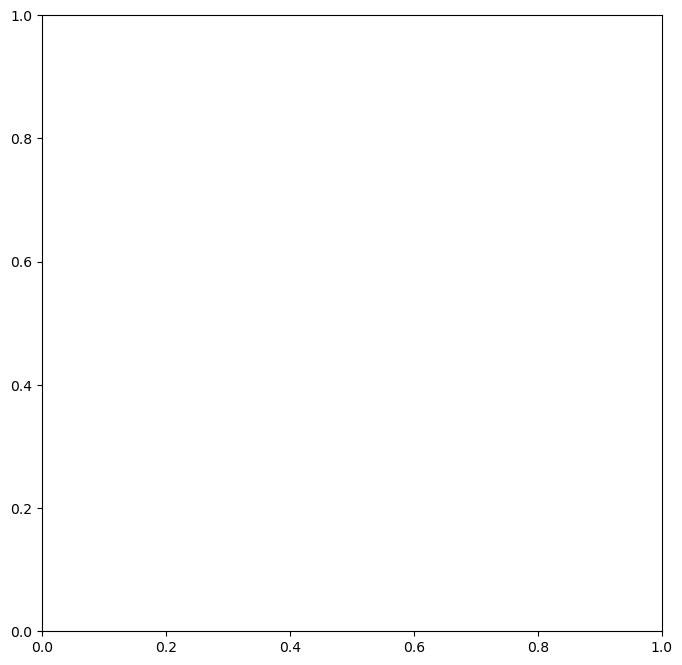

In [43]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.countplot(df_train['Label'])
ax.set_title('Distribution of Images', fontsize=14)
ax.set_xlabel('Label', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
plt.show()

There is a class imbalance pneumonia cases ~3x times the normal ones.

Let's define a function to resize the images and to augment. Some of the images has 3 channels and some one. Let's make all images to RGB.

In [11]:
def transform_image(img_list):
    img = cv2.resize(img_list, (224, 224))
    #cv2 reads image in BGR format. Let's convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img   

def augment_image(img_list):
    seq = iaa.OneOf([
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            rotate=(-25, 25)
        ),
        iaa.Fliplr(),
        iaa.Multiply((1.2, 1.5))
    ])
    return seq.augment_image(img_list)

def transform_augment_batch(img_path_list, label_list, is_augment=False):
    img_list = []
    for i in range(len(img_path_list)):
        img_list.append(transform_image(cv2.imread(str(img_path_list[i]))))
    n = len(img_list)
    if is_augment:
        for i in range(n):
            img = img_list[i]
            img = augment_image(img)
            img_list.append(img)
        img_list = np.array(img_list)
        label_list = np.append(label_list, label_list)
    return img_list, label_list

In [12]:
def generate_batch_images(df, batch_size):
    s = np.arange(df.shape[0])
    np.random.shuffle(s)
    X_dev = np.array(df_train.iloc[s, 0])
    Y_dev = np.array(df_train.iloc[s, 1])
    start_index = 0
    while start_index < len(X_dev):
        if start_index+batch_size <= len(X_dev):
            end_index = start_index+batch_size
        else:
            end_index = len(X_dev)
        #Select image paths in batches
        x_dev = X_dev[start_index:end_index]
        y_dev = Y_dev[start_index:end_index]
        
        #Transform images and augment
        x_dev, y_dev = transform_augment_batch(x_dev, y_dev, True)
        y_dev = y_dev.reshape((len(y_dev), 1))
        
        #Normalize
        x_dev = x_dev / 255.0
        yield x_dev, y_dev

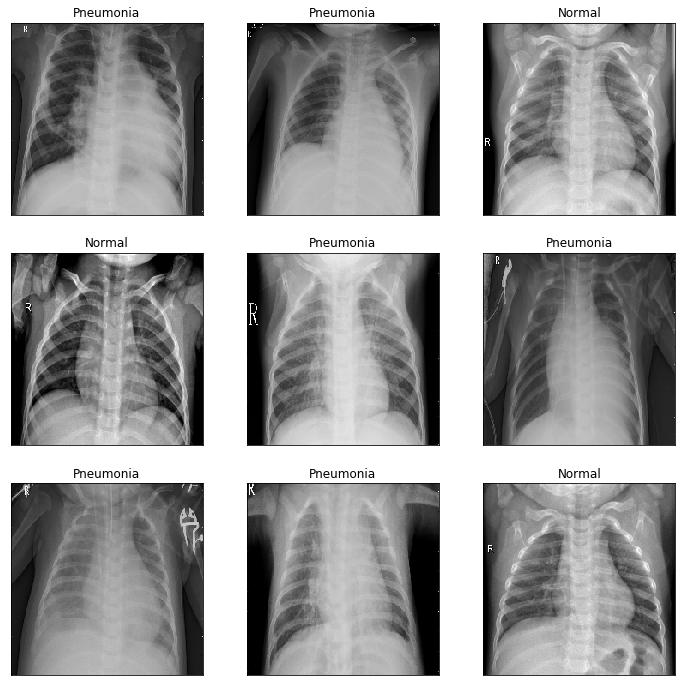

In [13]:
fig, ax = plt.subplots(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = transform_image(cv2.imread(str(df_train.iloc[i, 0])))
    plt.imshow(img)
    if df_train.iloc[i, 1] == 0:
        plt.title('Normal')
    else:
        plt.title('Pneumonia')
    plt.xticks([])
    plt.yticks([])
plt.show()

As we visualise the training samples after shuffling, there is a visible difference between the normal samples vs the pneumonia samples.

Let's visualise the samples after some augmentation.

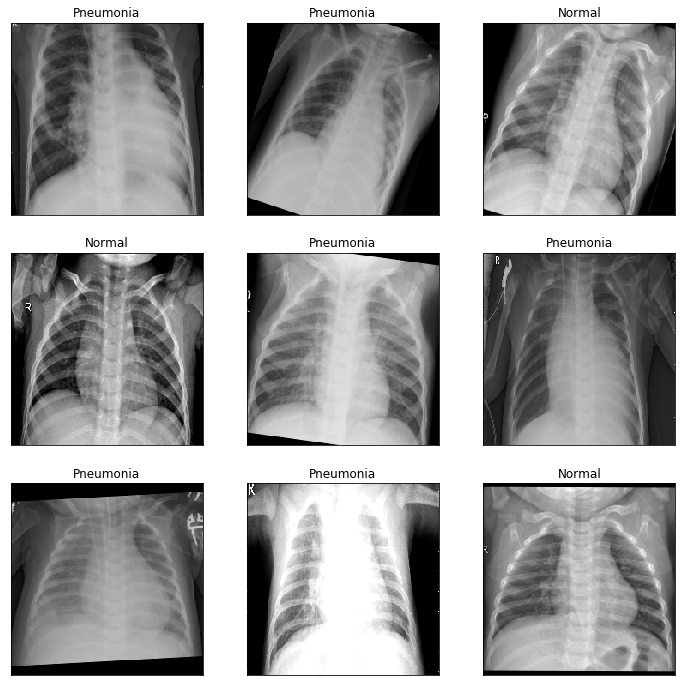

In [14]:
plt.subplots(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = transform_image(cv2.imread(str(df_train.iloc[i, 0])))
    img = augment_image(img)
    plt.imshow(img)
    if df_train.iloc[i, 1] == 0:
        plt.title('Normal')
    else:
        plt.title('Pneumonia')
    plt.xticks([])
    plt.yticks([])
plt.show()

# Let's arrange Validation and Test Data 

In [15]:
val_labels = np.array(df_val.iloc[:, 1]).reshape((df_val.shape[0], 1))
val_images, _ = transform_augment_batch(df_val.iloc[:, 0], df_val.iloc[:, 1], False)
val_images = np.array(val_images)
val_images = val_images / 255.0

In [16]:
val_images.shape, val_labels.shape

((16, 224, 224, 3), (16, 1))

In [ ]:
test_labels = np.array(df_test.iloc[:, 1]).reshape((df_test.shape[0], 1))
test_images, _ = transform_augment_batch(df_test.iloc[:, 0], df_test.iloc[:, 1], False)
test_images = np.array(test_images)
test_images = test_images / 255.0

In [ ]:
test_images.shape, test_labels.shape

# Deep Learning Model with Keras

In [ ]:
# Let's start with the hyperparameters
base_learning_rate = 1e-5
batch_size=32
epochs = 8

# Model

Defining the model in below function. Let's keep block -1,2,3 frozen and train blocks 4 and 5 along with adding Batch Norm.

In [ ]:
def create_model():
    img_input = Input(shape=(224, 224, 3))

    # Block 1
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='block1_conv1', trainable=False)(img_input)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='block1_conv2', trainable=False)(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block1_pool', trainable=False)(x)

    #Block 2
    x = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', name='block2_conv1',trainable=False)(x)
    x = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', name='block2_conv2', trainable=False)(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block2_pool', trainable=False)(x)

    #Block 3
    x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='block3_conv1',trainable=False)(x)
    x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='block3_conv2', trainable=False)(x)
    x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='block3_conv3', trainable=False)(x)
    x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='block3_conv4', trainable=False)(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block3_pool', trainable=False)(x)

    #Block 4
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block4_conv1')(x)
    x = BatchNormalization(name='block4_bn1')(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block4_conv2')(x)
    x = BatchNormalization(name='block4_bn2')(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block4_conv3')(x)
    x = BatchNormalization(name='block4_bn3')(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block4_conv4')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block4_pool')(x)

    #Block 5
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block5_conv1')(x)
    x = BatchNormalization(name='block5_bn1')(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block5_conv2')(x)
    x = BatchNormalization(name='block5_bn2')(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block5_conv3')(x)
    x = BatchNormalization(name='block5_bn3')(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block5_conv4')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block5_pool')(x)
    
    #Other layers
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout_1')(x)
    x = Dense(1000, activation='relu', name='fc2')(x)
    x = Dropout(0.7, name='dropout_2')(x)
    x = Dense(512, activation='relu', name='fc3')(x)
    x = Dropout(0.5, name='dropout_3')(x)
    x = Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = Model(inputs=img_input, outputs=x)
    return model

In [ ]:
base_model = VGG19(weights='imagenet', include_top=False)

In [ ]:
base_model.summary()

In [ ]:
model = create_model()
model.summary()

Now let's use the weights from Keras pre-trained model(VGG19) and apply to first 3 blocks of custom model and freeze it.

In [ ]:
layer_count = 0
for layer in model.layers:
    if layer.name[:6] in ['block1', 'block2', 'block3']:
        model.layers[layer_count].set_weights = base_model.layers[layer_count].get_weights()
    layer_count += 1

In [ ]:
adam = Adam(lr = base_learning_rate)
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=adam)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', 
                                patience=3, 
                                verbose=1, 
                                factor=0.2, 
                                min_lr=1e-7)

In [ ]:
model_chkpoint = ModelCheckpoint(filepath='vgg_19_best_model', save_best_only=True, save_weights_only=True)

In [ ]:
data_generator = generate_batch_images(df_train, batch_size)

In [ ]:
model.fit_generator(data_generator, epochs=epochs, steps_per_epoch=df_train.shape[0]/batch_size, 
                    callbacks=[reduce_lr, model_chkpoint], validation_data=[val_images, val_labels],
                    class_weight={0:3, 1:1})

# Let's plot the confusion matrix

In [ ]:
test_images.shape

In [ ]:
test_logits = model.predict(test_images, batch_size=16)

In [ ]:
# Evaluation on test dataset
test_loss, test_acc = model.evaluate(test_images, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_acc)

In [ ]:
cm  = confusion_matrix(test_labels, np.round(test_logits))
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Oranges)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

Let's check precision and recall. In this case, we should get a good recall than precision.

In [ ]:
true_negative, false_positive, false_negative, true_positive  = cm.ravel()
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

print('Precison of chest X-ray for pneumonia:{:.2f}'.format(precision))
print('Recall of chest X-ray for pneumonia:{:.2f}'.format(recall))

Happy coding. Please upvote if you like this kernel.